<a href="https://colab.research.google.com/github/StanKozurno/rep_1/blob/main/DataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
!pip install pycountry

In [146]:
#libraries for data preparation
import numpy as np
import pandas as pd
import pycountry

#libraries for data visualisation
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px


In [99]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Data Science')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
#df=pd.read_stata('easySHARE_rel8-0-0.dta')
risk=pd.read_csv('alcohol_risk.csv')
alcohol=pd.read_csv('alcohol_consumption.csv')
risk.head() 

,measure,location,sex,age,cause,rei,metric,year,val,upper,lower
0,Deaths,China,Male,All ages,Alcohol use disorders,All risk factors,Number,1990,7148.565277,11283.174225,5555.951852
1,Deaths,China,Female,All ages,Alcohol use disorders,All risk factors,Number,1990,2228.174753,2638.251635,1808.990970
2,Deaths,China,Both,All ages,Alcohol use disorders,All risk factors,Number,1990,9376.740030,13607.642843,7731.338734
3,Deaths,Algeria,Male,All ages,Alcohol use disorders,All risk factors,Number,1990,58.844275,80.095094,38.283751
4,Deaths,Algeria,Female,All ages,Alcohol use disorders,All risk factors,Number,1990,16.378712,21.204212,12.584821


In [101]:
!pwd

/content/drive/MyDrive/Data Science


# Nowa sekcja

In [102]:
def Analysis(data):
    print("Analysing")
    print(data.info())
    #calculating missing values
    missing = pd.concat([data.isnull().sum(), 100 * data.isnull().mean()], axis=1)
    missing.columns=['Count', '%']
    missing = missing.sort_values(by='Count', ascending=False)
    print(missing)
    df=missing.iloc[0:5,0]
Analysis(alcohol)

Analysing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Country Name   800 non-null    object
 1   Country Code   798 non-null    object
 2   Series Name    798 non-null    object
 3   Series Code    798 non-null    object
 4   1997 [YR1997]  798 non-null    object
 5   1998 [YR1998]  798 non-null    object
 6   1999 [YR1999]  798 non-null    object
 7   2000 [YR2000]  798 non-null    object
 8   2001 [YR2001]  798 non-null    object
 9   2002 [YR2002]  798 non-null    object
 10  2003 [YR2003]  798 non-null    object
 11  2004 [YR2004]  798 non-null    object
 12  2005 [YR2005]  798 non-null    object
 13  2006 [YR2006]  798 non-null    object
 14  2007 [YR2007]  798 non-null    object
 15  2008 [YR2008]  798 non-null    object
 16  2009 [YR2009]  798 non-null    object
 17  2010 [YR2010]  798 non-null    object
 18  2011 [YR2011]  798 n

In [103]:
#creating a function to rename columns 
def rename(df):
    return df.rename(columns = lambda x : str(x)[:-9])
#    for column in df.iloc[:,8:]:

In [104]:
nan_value = float("NaN") #Convert NaN values to empty string.
alcohol.replace("", nan_value, inplace=True)
alcohol.replace("..", nan_value, inplace=True)
alcohol.dropna(subset = ["Country Code"], inplace=True)
alcohol.dropna(how='all', axis=1, inplace=True)
alcohol.tail()

,Country Name,Country Code,Series Name,Series Code,2000 [YR2000],2005 [YR2005],2010 [YR2010],2015 [YR2015],2018 [YR2018]
793,Upper middle income,UMC,"Total alcohol consumption per capita, female (...",SH.ALC.PCAP.FE.LI,2.47289185170729,2.56488555274709,3.2264376937366,3.05922764679845,2.97565290858531
794,Upper middle income,UMC,"Total alcohol consumption per capita, male (li...",SH.ALC.PCAP.MA.LI,9.11499568520199,9.24095435101661,11.8686860962916,11.3133478387704,10.9681968239619
795,World,WLD,Total alcohol consumption per capita (liters o...,SH.ALC.PCAP.LI,5.48833592001259,5.42883274560048,6.28376529381833,6.29895560219615,6.18263453990771
796,World,WLD,"Total alcohol consumption per capita, female (...",SH.ALC.PCAP.FE.LI,2.41677855873695,2.40128503418862,2.69579450515509,2.66650870063011,2.6143378101529
797,World,WLD,"Total alcohol consumption per capita, male (li...",SH.ALC.PCAP.MA.LI,8.57460077546411,8.46375781956192,9.87635503128966,9.92837831418947,9.74729824850882


In [105]:
merge=alcohol.iloc[:,:4]
alcohol.rename(columns={alcohol.columns[0]: "Country         ",alcohol.columns[2]: "Measure         "}, inplace = True)
alcohol.rename(columns={alcohol.columns[1]: "ISO         "}, inplace = True)
alcohol.head()

,Country,ISO,Measure,Series Code,2000 [YR2000],2005 [YR2005],2010 [YR2010],2015 [YR2015],2018 [YR2018]
0,Afghanistan,AFG,Total alcohol consumption per capita (liters o...,SH.ALC.PCAP.LI,NaN,NaN,0.21,0.21,0.21
1,Afghanistan,AFG,"Total alcohol consumption per capita, female (...",SH.ALC.PCAP.FE.LI,NaN,NaN,0.054,0.054,0.055
2,Afghanistan,AFG,"Total alcohol consumption per capita, male (li...",SH.ALC.PCAP.MA.LI,NaN,NaN,0.36,0.35,0.36
3,Albania,ALB,Total alcohol consumption per capita (liters o...,SH.ALC.PCAP.LI,6.57,7.65,7.69,6.74,7.17
4,Albania,ALB,"Total alcohol consumption per capita, female (...",SH.ALC.PCAP.FE.LI,2.5,2.96,2.98,2.53,2.68


In [106]:
alcohol=rename(alcohol)
#.iloc[:,-24:]

In [107]:
alcohol.drop(["Se"],axis=1,inplace=True)

alcohol.head()


,Country,ISO,Measure,2000,2005,2010,2015,2018
0,Afghanistan,AFG,Total alcohol consumption per capita (liters o...,NaN,NaN,0.21,0.21,0.21
1,Afghanistan,AFG,"Total alcohol consumption per capita, female (...",NaN,NaN,0.054,0.054,0.055
2,Afghanistan,AFG,"Total alcohol consumption per capita, male (li...",NaN,NaN,0.36,0.35,0.36
3,Albania,ALB,Total alcohol consumption per capita (liters o...,6.57,7.65,7.69,6.74,7.17
4,Albania,ALB,"Total alcohol consumption per capita, female (...",2.5,2.96,2.98,2.53,2.68


In [108]:
alcohol = pd.melt(alcohol,id_vars=['Country','ISO','Measure'],
                        var_name='Year',
                        value_name='Rate')
alcohol.head()

,Country,ISO,Measure,Year,Rate
0,Afghanistan,AFG,Total alcohol consumption per capita (liters o...,2000,NaN
1,Afghanistan,AFG,"Total alcohol consumption per capita, female (...",2000,NaN
2,Afghanistan,AFG,"Total alcohol consumption per capita, male (li...",2000,NaN
3,Albania,ALB,Total alcohol consumption per capita (liters o...,2000,6.57
4,Albania,ALB,"Total alcohol consumption per capita, female (...",2000,2.5


In [109]:
alcohol.rename({'Measure':'Sex','Rate':'Alcohol consumption'},inplace=True,axis=1)
alcohol.head()

,Country,ISO,Sex,Year,Alcohol consumption
0,Afghanistan,AFG,Total alcohol consumption per capita (liters o...,2000,NaN
1,Afghanistan,AFG,"Total alcohol consumption per capita, female (...",2000,NaN
2,Afghanistan,AFG,"Total alcohol consumption per capita, male (li...",2000,NaN
3,Albania,ALB,Total alcohol consumption per capita (liters o...,2000,6.57
4,Albania,ALB,"Total alcohol consumption per capita, female (...",2000,2.5


In [110]:
alcohol['Sex'].replace({'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)':'Total',
                'Total alcohol consumption per capita, female (liters of pure alcohol, projected estimates, female 15+ years of age)':'Female',
               'Total alcohol consumption per capita, male (liters of pure alcohol, projected estimates, male 15+ years of age)':'Male'},
               inplace=True)
alcohol=alcohol[['Country','ISO','Year','Sex','Alcohol consumption']]
alcohol.head()

,Country,ISO,Year,Sex,Alcohol consumption
0,Afghanistan,AFG,2000,Total,NaN
1,Afghanistan,AFG,2000,Female,NaN
2,Afghanistan,AFG,2000,Male,NaN
3,Albania,ALB,2000,Total,6.57
4,Albania,ALB,2000,Female,2.5


In [111]:
Analysis(risk)
risk.head()

Analysing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18360 entries, 0 to 18359
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   measure   18360 non-null  object 
 1   location  18360 non-null  object 
 2   sex       18360 non-null  object 
 3   age       18360 non-null  object 
 4   cause     18360 non-null  object 
 5   rei       18360 non-null  object 
 6   metric    18360 non-null  object 
 7   year      18360 non-null  int64  
 8   val       18360 non-null  float64
 9   upper     18360 non-null  float64
 10  lower     18360 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 1.5+ MB
None
          Count    %
measure       0  0.0
location      0  0.0
sex           0  0.0
age           0  0.0
cause         0  0.0
rei           0  0.0
metric        0  0.0
year          0  0.0
val           0  0.0
upper         0  0.0
lower         0  0.0


,measure,location,sex,age,cause,rei,metric,year,val,upper,lower
0,Deaths,China,Male,All ages,Alcohol use disorders,All risk factors,Number,1990,7148.565277,11283.174225,5555.951852
1,Deaths,China,Female,All ages,Alcohol use disorders,All risk factors,Number,1990,2228.174753,2638.251635,1808.990970
2,Deaths,China,Both,All ages,Alcohol use disorders,All risk factors,Number,1990,9376.740030,13607.642843,7731.338734
3,Deaths,Algeria,Male,All ages,Alcohol use disorders,All risk factors,Number,1990,58.844275,80.095094,38.283751
4,Deaths,Algeria,Female,All ages,Alcohol use disorders,All risk factors,Number,1990,16.378712,21.204212,12.584821


In [112]:
risk=risk.drop(columns=['age','upper','measure','rei','lower','cause','metric'])
risk.head()

,location,sex,year,val
0,China,Male,1990,7148.565277
1,China,Female,1990,2228.174753
2,China,Both,1990,9376.740030
3,Algeria,Male,1990,58.844275
4,Algeria,Female,1990,16.378712


In [113]:
def findCountry (country_name):
    try:
        return pycountry.countries.get(name=country_name).alpha_3
    except:
        return ("not founded")
risk['ISO'] = risk.apply(lambda row: findCountry(row.location) , axis = 1)

In [114]:
risk.rename({'location':'Country', 'year':'Year','val':'Alcohol disorders','sex':'Sex'},inplace=True,axis=1)
risk.head()

,Country,Sex,Year,Alcohol disorders,ISO
0,China,Male,1990,7148.565277,CHN
1,China,Female,1990,2228.174753,CHN
2,China,Both,1990,9376.740030,CHN
3,Algeria,Male,1990,58.844275,DZA
4,Algeria,Female,1990,16.378712,DZA


In [115]:
risk=risk[['Country','ISO','Year','Alcohol disorders','Sex']]
risk['Sex'].replace({'Both':'Total'}, inplace=True)
risk.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,Country,ISO,Year,Alcohol disorders,Sex
0,China,CHN,1990,7148.565277,Male
1,China,CHN,1990,2228.174753,Female
2,China,CHN,1990,9376.740030,Total
3,Algeria,DZA,1990,58.844275,Male
4,Algeria,DZA,1990,16.378712,Female


In [116]:
risk.info()
alcohol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18360 entries, 0 to 18359
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            18360 non-null  object 
 1   ISO                18360 non-null  object 
 2   Year               18360 non-null  int64  
 3   Alcohol disorders  18360 non-null  float64
 4   Sex                18360 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 717.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3990 entries, 0 to 3989
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Country              3990 non-null   object
 1   ISO                  3990 non-null   object
 2   Year                 3990 non-null   object
 3   Sex                  3990 non-null   object
 4   Alcohol consumption  3492 non-null   object
dtypes: object(5)
memory usage: 156.0+ KB


In [117]:
alcohol["Year"] = pd.to_numeric(alcohol["Year"])
alcohol["Alcohol consumption"] = pd.to_numeric(alcohol["Alcohol consumption"])


In [118]:
alcohol=alcohol.merge(risk,how='inner',on=['Country','ISO','Year','Sex'])
alcohol.head(300)

,Country,ISO,Year,Sex,Alcohol consumption,Alcohol disorders
0,Afghanistan,AFG,2000,Total,NaN,99.104809
1,Afghanistan,AFG,2000,Female,NaN,32.837202
2,Afghanistan,AFG,2000,Male,NaN,66.267607
3,Albania,ALB,2000,Total,6.570,14.501601
4,Albania,ALB,2000,Female,2.500,1.877471
...,...,...,...,...,...,...
295,Marshall Islands,MHL,2000,Female,NaN,0.061099
296,Marshall Islands,MHL,2000,Male,NaN,0.593071
297,Mauritania,MRT,2000,Total,0.200,12.940386
298,Mauritania,MRT,2000,Female,0.053,2.448008


In [143]:
Analysis(alcohol)

Analysing
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2610 entries, 0 to 2609
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              2610 non-null   object 
 1   ISO                  2610 non-null   object 
 2   Year                 2610 non-null   int64  
 3   Sex                  2610 non-null   object 
 4   Alcohol consumption  2412 non-null   float64
 5   Alcohol disorders    2610 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 142.7+ KB
None
                     Count         %
Alcohol consumption    198  7.586207
Country                  0  0.000000
ISO                      0  0.000000
Year                     0  0.000000
Sex                      0  0.000000
Alcohol disorders        0  0.000000


# Data visualisation

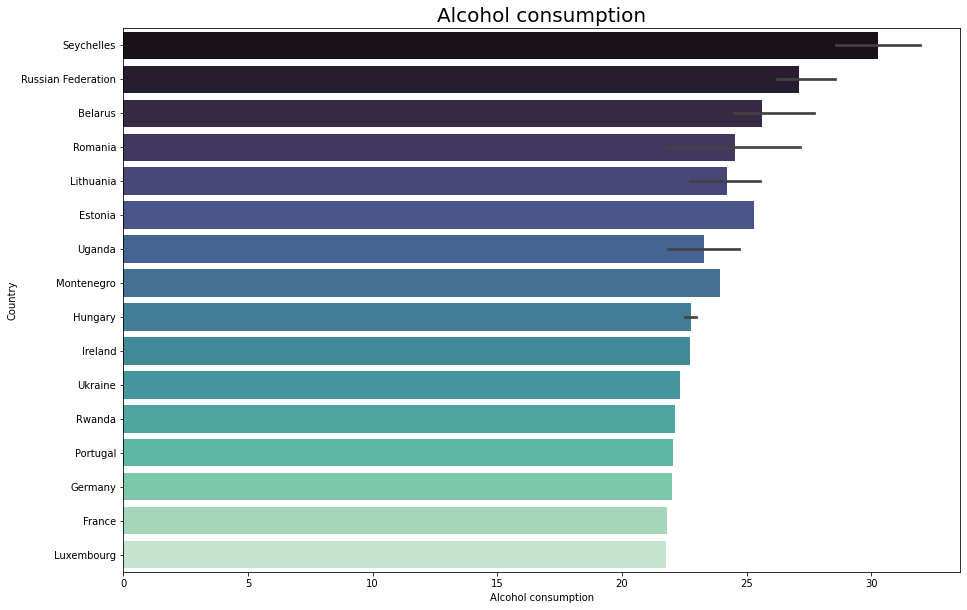

In [133]:
plt.figure(figsize = (15,10))
sns.barplot(x ='Alcohol consumption',y= 'Country',data = alcohol.nlargest(30,'Alcohol consumption',keep='first'),palette='mako')
plt.title('Alcohol consumption', fontsize = 20)
plt.show()

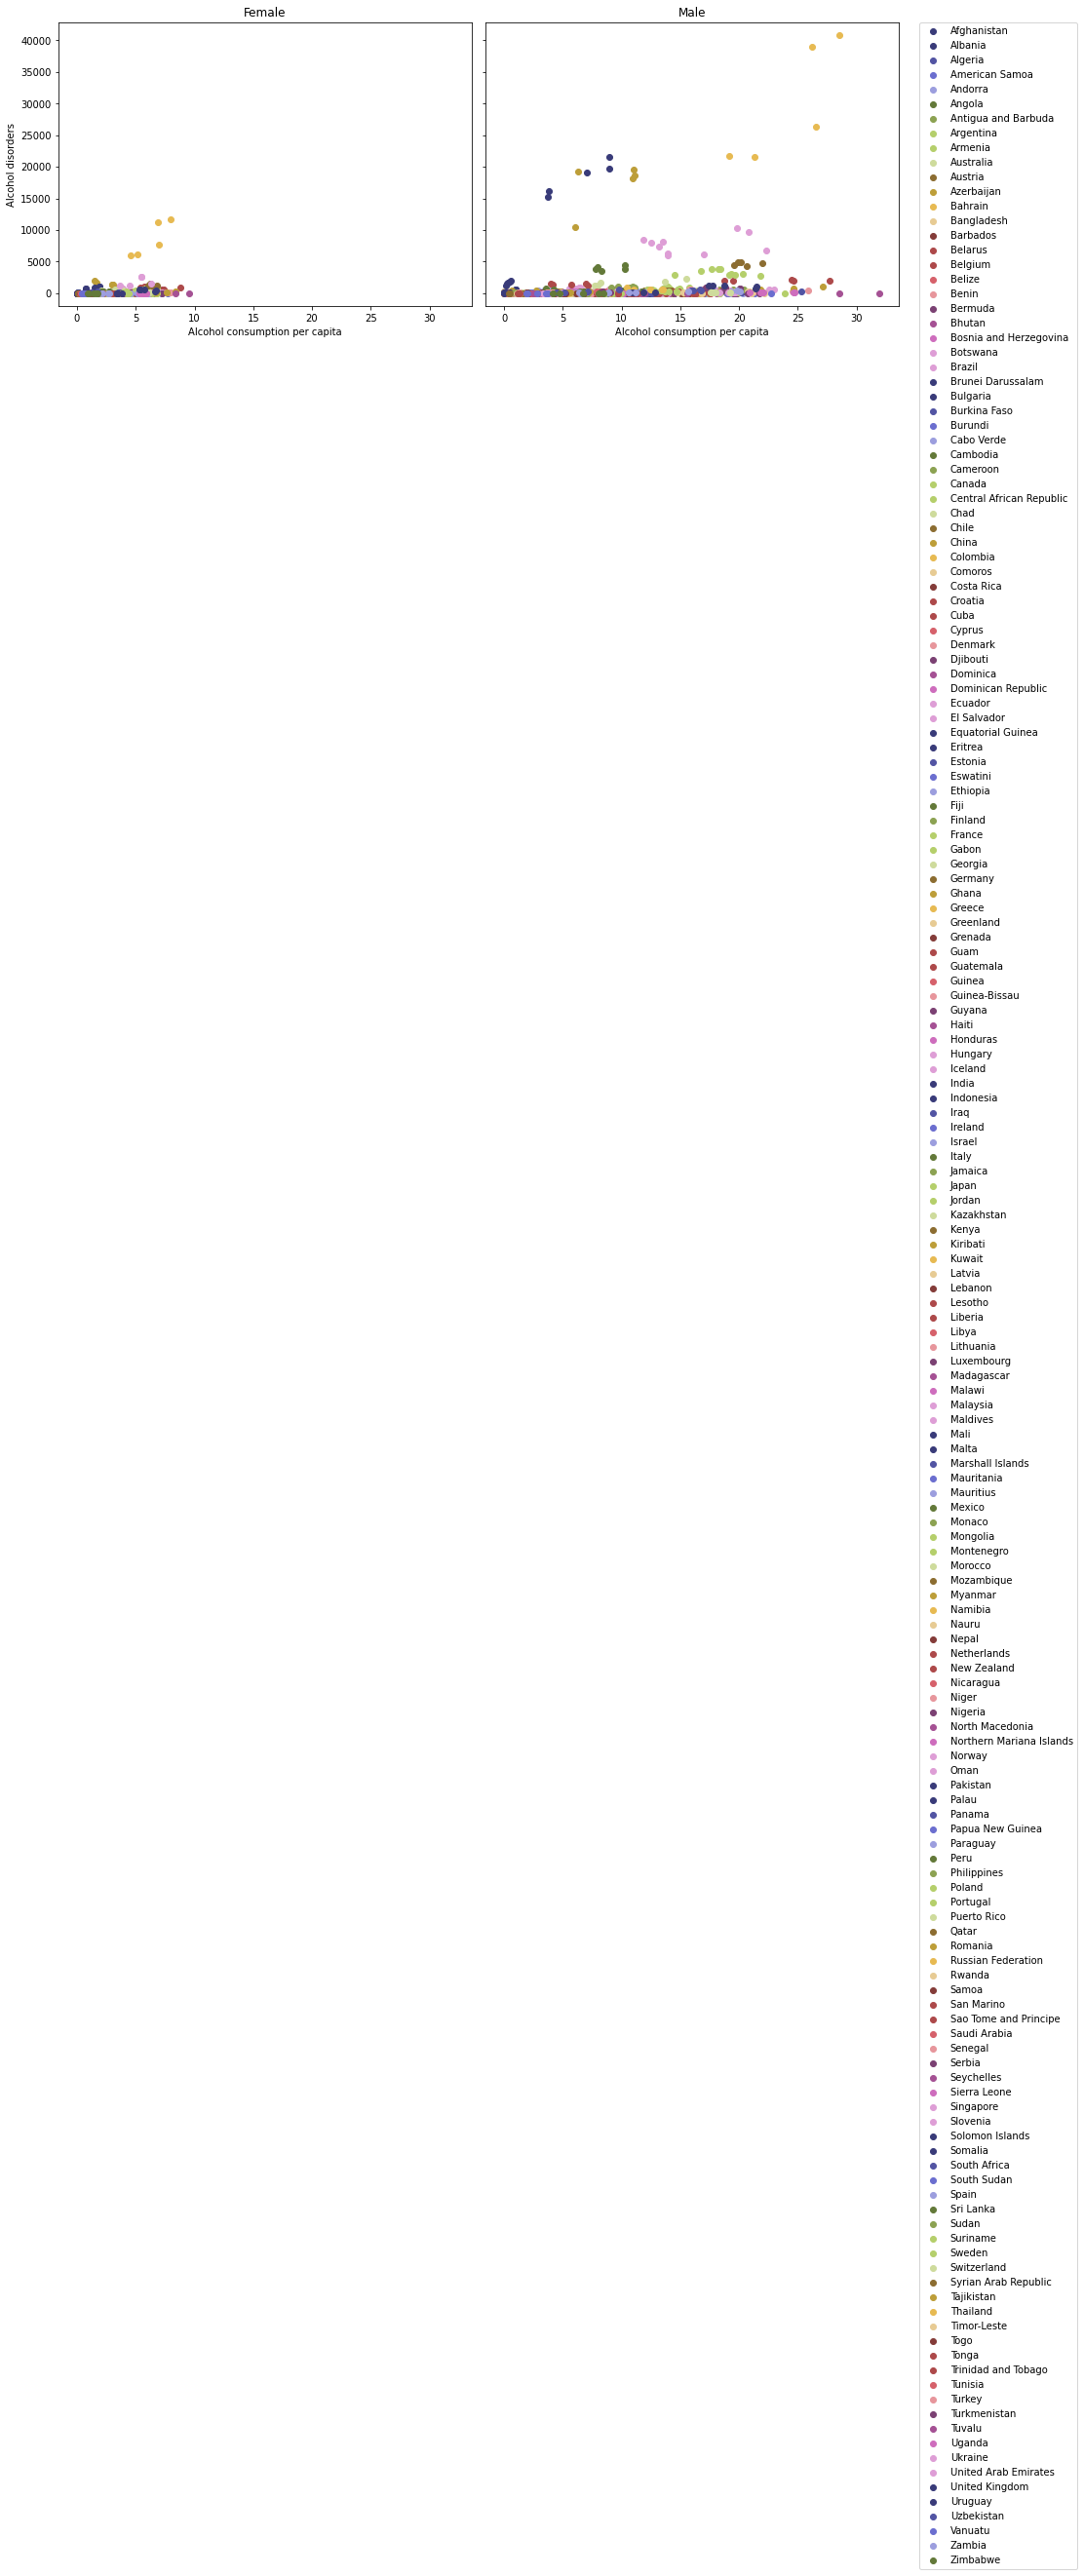

In [145]:
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.cm as mplcm
import numpy as np
import statsmodels.api as sm

plt.style.use('seaborn-dark-palette')
NUM_COLORS = 24

cm = plt.get_cmap('tab20b')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=([scalarMap.to_rgba(i) for i in range(NUM_COLORS)]))
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True,figsize=(13,5))


for Country in alcohol.Country.unique():
    mask = (alcohol.Country == Country)
    ax1.scatter(alcohol[mask&(alcohol.Sex=='Female')]['Alcohol consumption'], alcohol[mask&(alcohol.Sex=='Female')]['Alcohol disorders'], label = Country)
    ax2.scatter(alcohol[mask&(alcohol.Sex=='Male')]['Alcohol consumption'], alcohol[mask&(alcohol.Sex=='Male')]['Alcohol disorders'], label = Country)


ax1.set_xlabel('Alcohol consumption per capita')
ax2.set_xlabel('Alcohol consumption per capita')
ax1.set_ylabel('Alcohol disorders')
ax1.set_title('Female')
ax2.set_title('Male')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

In [147]:
fig = px.choropleth(alcohol, locations="ISO",
                    color="Alcohol consumption", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [148]:
fig = px.choropleth(alcohol, locations="ISO", #ISO is used to recognize a country
                    color="Alcohol disorders", # this is a visualised column
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()